## Create stations population shapefile

Reads population and station shapefiles. Creates 500 meters buffer around stations, then calculates population size for every station and year and saves result to population_data folder as stations_population shapefile.

#### Import libraries

In [1]:
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx

#### Read station and population files

In [2]:
# Read population shapefile
fp = "population_data/population.shp"
population = gpd.read_file(fp)

# Read stations shapefile
fp = "stations_data/stations.shp"
stations = gpd.read_file(fp)

# Show first rows of stations dataframe
stations.head(3)

,Name,Opened,Type,geometry
0,Espoo,1903,Train,POINT (2744784.758 8445625.162)
1,Helsinki Center Station,1862,Train/Metro,POINT (2776450.701 8437894.974)
2,Hiekkaharju,1931,Train,POINT (2788487.121 8467534.963)


#### Create buffer around stations with radius of 500 meters

In [3]:
# Copy dataframe stations
buffer = stations

# Rename buffer geometry as coordinate
buffer["coordinate"] = buffer["geometry"]

# Change crs to metric system to create buffer around stations with radius 500 meters
buffer = stations.to_crs(epsg=3395)

# Create buffer with radius 1000 meters (area where is less than 500 meters to station)
buffer["geometry"] = buffer.buffer(1000, cap_style=1)

# Change crs back to crs 3857
buffer = buffer.to_crs(epsg=3857)

# Show first rows
buffer.head(3)

,Name,Opened,Type,geometry,coordinate
0,Espoo,1903,Train,"POLYGON ((2745784.758 8445625.162, 2745779.943...",POINT (2744784.758 8445625.162)
1,Helsinki Center Station,1862,Train/Metro,"POLYGON ((2777450.701 8437894.974, 2777445.885...",POINT (2776450.701 8437894.974)
2,Hiekkaharju,1931,Train,"POLYGON ((2789487.121 8467534.963, 2789482.305...",POINT (2788487.121 8467534.963)


#### Plot buffer around stations to make sure it looks correct

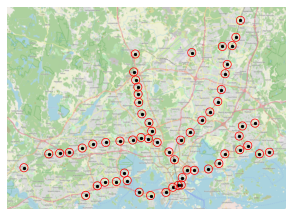

In [4]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(5,5))

# Plot rails
stations.plot(ax=ax, color="black", markersize=5)

# Plot stations
buffer.plot(ax=ax, facecolor="none", edgecolor='red', lw=0.7)

# remove the axis
ax.axis("off")

# Add basemap with `OMS_A` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

### Calculate population in buffers

#### Find centroid of each population grid and then make spatial join between population centroids and stations buffers

In [5]:
# Change population crs to match crs in buffer dataframe
population = population.to_crs(epsg=3857)

# Calculate population centroid
population["geometry"] = population.centroid

# Find all the population centroids inside the stations buffers
stations_population = gpd.sjoin(buffer, population, op='contains', how='inner')

# Temporary drop columns which would confuce calculating group sum
stations_population = stations_population.drop(columns=['geometry','coordinate', 'Type', "Opened"])

# Group data by index and calculate population sum on each station
stations_population = stations_population.groupby(stations_population.index).sum()

# Merge stations_population with original stations table to get back dropped columns
stations_population = pd.merge(stations, stations_population, left_index=True, right_index=True)

# Drop column index_right, which is old index of population dataframe
stations_population = stations_population.drop(columns=["index_right"])

# Show first rows
stations_population.head(3)

,Name,Opened,Type,geometry,coordinate,pop1997,pop1998,pop1999,pop2000,pop2001,...,pop2010,pop2011,pop2012,pop2013,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019
0,Espoo,1903,Train,POINT (2744784.758 8445625.162),POINT (2744784.758 8445625.162),3604,3642,2195,2142,3484,...,3537,3637,4003,3952,4229,4256,4356,4206,4400,4173
1,Helsinki Center Station,1862,Train/Metro,POINT (2776450.701 8437894.974),POINT (2776450.701 8437894.974),546,518,711,713,497,...,493,479,523,533,562,556,550,545,581,594
2,Hiekkaharju,1931,Train,POINT (2788487.121 8467534.963),POINT (2788487.121 8467534.963),2513,2616,2808,2768,2635,...,2699,2683,2701,2702,2672,2660,2666,2685,2663,2668


#### Change stations_population geometry to be buffer geometry. Will create circles around stations with total population

In [6]:
# Copy buffer Name and buffer geometry to new dataframe
buffer_polygon = buffer[["Name", "geometry"]]

# Drop column geometry and coordinate
stations_population = stations_population.drop(columns=['geometry', 'coordinate'])

# Add buffer polygon to stations_population
stations_population = stations_population.merge(buffer_polygon, on='Name')

# Show firs rows
stations_population.head(3)

,Name,Opened,Type,pop1997,pop1998,pop1999,pop2000,pop2001,pop2002,pop2003,...,pop2011,pop2012,pop2013,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019,geometry
0,Espoo,1903,Train,3604,3642,2195,2142,3484,3469,3467,...,3637,4003,3952,4229,4256,4356,4206,4400,4173,"POLYGON ((2745784.758 8445625.162, 2745779.943..."
1,Helsinki Center Station,1862,Train/Metro,546,518,711,713,497,483,474,...,479,523,533,562,556,550,545,581,594,"POLYGON ((2777450.701 8437894.974, 2777445.885..."
2,Hiekkaharju,1931,Train,2513,2616,2808,2768,2635,2650,2681,...,2683,2701,2702,2672,2660,2666,2685,2663,2668,"POLYGON ((2789487.121 8467534.963, 2789482.305..."


#### Reorder columns to make it easier to read

In [7]:
# Get columns names
columns = stations_population.columns.tolist()

# Sort columns alphabetically
columns = sorted(columns)

# Set new order to dataframe
stations_population = stations_population[columns]

# Show first rows
stations_population.head(3)

,Name,Opened,Type,geometry,pop1997,pop1998,pop1999,pop2000,pop2001,pop2002,...,pop2010,pop2011,pop2012,pop2013,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019
0,Espoo,1903,Train,"POLYGON ((2745784.758 8445625.162, 2745779.943...",3604,3642,2195,2142,3484,3469,...,3537,3637,4003,3952,4229,4256,4356,4206,4400,4173
1,Helsinki Center Station,1862,Train/Metro,"POLYGON ((2777450.701 8437894.974, 2777445.885...",546,518,711,713,497,483,...,493,479,523,533,562,556,550,545,581,594
2,Hiekkaharju,1931,Train,"POLYGON ((2789487.121 8467534.963, 2789482.305...",2513,2616,2808,2768,2635,2650,...,2699,2683,2701,2702,2672,2660,2666,2685,2663,2668


#### Plot stations population in 2019 to see it works

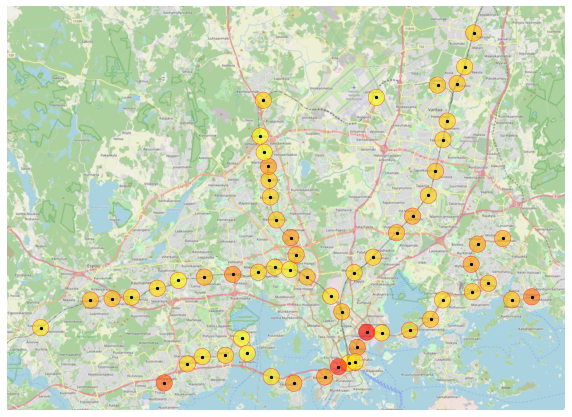

In [8]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10,10))

# Plot buffer population grid
stations_population.plot(ax=ax, column='pop2019', edgecolor='red', cmap='autumn_r', linewidth=0.5, alpha=0.6)

# Plot stations
stations.plot(ax=ax, color="black", markersize=5)

# remove the axis
ax.axis("off")

# Add basemap with `OMS_A` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

### Save stations population

In [9]:
# Write to Shapefile
outfp = "population_data/stations_population.shp"
stations_population.to_file(outfp)